# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [1]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from functions_variables_blair import *
from pandas import json_normalize
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns



## Data Importing

In [2]:
# load one file first to see what type of data you're dealing with and what attributes it has
df = pd.read_json('../data/AL_Montgomery_3.json')
df

,status,data
total,200,895
count,200,42
results,200,[{'primary_photo': {'href': 'https://ap.rdcpix...


In [62]:
# # Accessing the first dictionary in the results list
# first_result = df['data']['results'][0]
# pprint(first_result)

In [63]:
# # Iterating over all dictionaries in the results list
# for result in df['data']['results']:
#     print(result)




In [64]:
# # Convert the results list of dictionaries into a DataFrame
# df_result = pd.DataFrame(data['data']['results'])

# df_result.head()

In [65]:
# # Normalize the nested dictionaries
# df_result_normalized = json_normalize(data['data']['results'])
# df_result_normalized.head()


In [3]:
# loop over all files and put them into a dataframe
# Define the path to the data folder
data_folder = '../data'

# Initialize an empty list to store DataFrames
df_list = []

# Loop through each file in the data folder
for filename in os.listdir(data_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(data_folder, filename)
        
        # Open and load the JSON file
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        
        # Normalize the 'data.results' key
        if 'data' in json_data and 'results' in json_data['data']:
            df_normalized = json_normalize(json_data['data']['results'])
            df_list.append(df_normalized)

# Concatenate all DataFrames in the list
df_result = pd.concat(df_list, ignore_index=True)

# # Display the concatenated DataFrame
# len(df_result)
# df_result.head(2)

C:\Users\Ikemma\AppData\Local\Temp\ipykernel_56736\3271259705.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat(df_list, ignore_index=True)


## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

In [67]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 67 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       8125 non-null   object 
 1   tags                                   7638 non-null   object 
 2   permalink                              8159 non-null   object 
 3   status                                 8159 non-null   object 
 4   list_date                              7752 non-null   object 
 5   open_houses                            0 non-null      object 
 6   branding                               8159 non-null   object 
 7   list_price                             7721 non-null   float64
 8   property_id                            8159 non-null   object 
 9   photos                                 7403 non-null   object 
 10  community                              0 non-null      object 
 11  virt

In [68]:
df_result.describe()

,list_price,price_reduced_amount,description.year_built,description.baths_3qtr,description.sold_price,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,description.baths,description.garage,description.stories,description.beds,location.address.coordinate.lon,location.address.coordinate.lat,location.county
count,7.721000e+03,2.484000e+03,7316.000000,566.000000,6.716000e+03,7311.000000,2281.000000,6.991000e+03,7323.000000,7980.000000,4448.000000,6260.000000,7504.000000,7909.000000,7909.000000,0.0
mean,4.341582e+05,2.442704e+04,1968.916074,1.247350,4.126050e+05,1.887430,1.105655,2.510949e+05,1933.848559,2.131203,1.926709,1.567732,3.208289,-92.206522,39.009689,NaN
std,5.514925e+05,7.162396e+04,35.096914,0.463482,6.994308e+05,0.862214,0.413340,5.823820e+06,1339.039206,1.175940,0.878766,0.730969,1.282732,15.888886,4.374553,NaN
min,1.000000e+00,1.000000e+02,1828.000000,1.000000,3.080000e+02,1.000000,1.000000,0.000000e+00,120.000000,0.000000,1.000000,1.000000,0.000000,-157.810583,21.277707,NaN
25%,2.090000e+05,6.000000e+03,1950.000000,1.000000,1.910000e+05,1.000000,1.000000,4.953000e+03,1258.000000,1.000000,1.000000,1.000000,3.000000,-104.971611,35.688084,NaN
50%,3.250000e+05,1.010000e+04,1975.000000,1.000000,3.140000e+05,2.000000,1.000000,7.841000e+03,1635.000000,2.000000,2.000000,1.000000,3.000000,-89.333131,39.698210,NaN
75%,4.999000e+05,2.000000e+04,1997.000000,1.000000,4.700000e+05,2.000000,1.000000,1.263200e+04,2264.000000,3.000000,2.000000,2.000000,4.000000,-78.617690,41.832266,NaN
max,1.250000e+07,2.015999e+06,2024.000000,3.000000,2.706500e+07,8.000000,5.000000,1.676624e+08,32106.000000,9.000000,11.000000,10.000000,12.000000,-71.006343,58.396178,NaN


In [5]:
# check missing values
df_result.isna().sum()

last_update_date                 66
tags                            553
permalink                        32
status                           32
list_date                       439
                               ... 
location.address.coordinate    8191
other_listings                 8191
community.advertisers          8186
community.description.name     8186
location.county                8191
Length: 67, dtype: int64

From the above we have some columns with no values. We will deal with missing values for the target variable sold_price first and check other features that have missing values.

In [69]:
# Drop rows without a sold_price
df_result = df_result.dropna(subset=['description.sold_price'])
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6716 entries, 0 to 8190
Data columns (total 67 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       6696 non-null   object 
 1   tags                                   6330 non-null   object 
 2   permalink                              6716 non-null   object 
 3   status                                 6716 non-null   object 
 4   list_date                              6429 non-null   object 
 5   open_houses                            0 non-null      object 
 6   branding                               6716 non-null   object 
 7   list_price                             6429 non-null   float64
 8   property_id                            6716 non-null   object 
 9   photos                                 6273 non-null   object 
 10  community                              0 non-null      object 
 11  virtual_t

Length of target values now equals length of the rows in our data. We will now deal with other features

In [6]:
# Calculate the 95th/5th percentile of the description.sold_price column
percentile_5 = df_result['description.sold_price'].quantile(0.05)
percentile_95 = df_result['description.sold_price'].quantile(0.95)

# Filter out rows where description.sold_price is below the 5th percentile or above the 95th percentile
df_result = df_result[(df_result['description.sold_price'] >= percentile_5) & (df_result['description.sold_price'] <= percentile_95)]



In [19]:
# List of columns to drop based off not adding value to the model or are too
# highly correlated or are missing too many values
# List of columns to drop
columns_to_drop = [
    'open_houses', 'community', 'description.name', 'description.baths_1qtr',
    'flags.is_new_construction', 'flags.is_for_rent', 'flags.is_subdivision',
    'flags.is_contingent', 'flags.is_pending', 'flags.is_plan', 'flags.is_coming_soon',
    'community.advertisers', 'community.description.name', 'source.plan_id',
    'source.spec_id', 'products', 'other_listings', 'location.address.coordinate',
    'primary_photo', 'source', 'last_update_date', 'permalink', 'branding', 'listing_id',
    'matterport', 'lead_attributes.show_contact_an_agent', 'products.brand_name',
    'other_listings.rdc', 'location.street_view_url', 'location.county.fips_code',
    'location.county.name', 'description.baths_3qtr',
    'description.baths_half',  'description.baths_1qtr',
    'description.sub_type', 'flags.is_price_reduced', 'flags.is_foreclosure',
    'flags.is_new_listing', 'location.county', 'virtual_tours', 'list_price', 'property_id', 'status', 'location.address.line', 'location.address.postal_code',
    'location.address.coordinate.lon', 'location.address.coordinate.lat', 'price_reduced_amount',
    'location.address.state_code', 'location.address.line', 'source.agents', 'source.type', 'location.address.state',
    'primary_photo.href', 'photos',  'description.lot_sqft', 'description.baths_full', 
    #  'description.sold_date', 'description.baths_full',
]

# Drop the columns
df_result = df_result.drop(columns=columns_to_drop)

# Display the DataFrame
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6048 entries, 30 to 8185
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tags                    5754 non-null   object 
 1   list_date               5813 non-null   object 
 2   description.year_built  5572 non-null   float64
 3   description.sold_date   6048 non-null   object 
 4   description.sold_price  6048 non-null   float64
 5   description.sqft        5596 non-null   float64
 6   description.baths       5920 non-null   float64
 7   description.garage      3255 non-null   float64
 8   description.stories     4714 non-null   float64
 9   description.beds        5689 non-null   float64
 10  description.type        6028 non-null   object 
 11  location.address.city   6043 non-null   object 
dtypes: float64(7), object(5)
memory usage: 614.2+ KB


In [ ]:
# check cities with highest number to occurance
df_result[['location.address.city']].value_counts()

location.address.city
Lincoln                  210
Dover                    210
Tallahassee              206
Indianapolis             205
Salem                    205
                        ... 
Alexander                  2
Tolleson                   1
Galloway                   1
Hermitage                  1
Honolulu                   1
Name: count, Length: 83, dtype: int64

In [25]:
# Fill in the location.address.city from using Ohio's city with the most occurences
df_result['location.address.city'] = df_result['location.address.city'].fillna('Lincoln')

# # Fill NaN values in 'description.garage' with 0
# df_result['description.garage'] = df_result['description.garage'].fillna(0)

# # Fill NaN values in 'description.stories' with 0
# mean_stories = df_result['description.stories'].mean()
# df_result['description.stories'] = df_result['description.stories'].fillna(mean_stories)



In [26]:
# Use Knn to fill NaN values in 'description.year_built' with the median
knn_imputer = KNNImputer(n_neighbors=5)
df_result[['description.sqft']] = knn_imputer.fit_transform(df_result[['description.sqft']])
df_result[['description.year_built']] = knn_imputer.fit_transform(df_result[['description.year_built']])

# description.year_built = df_result['description.year_built'].median()
# df_result['description.year_built'] = df_result['description.year_built'].fillna(description.year_built)

# # Fill NaN values in 'description.sqft' with the mean
# mean_sqft = df_result['description.sqft'].mean()
# df_result['description.sqft'] = df_result['description.sqft'].fillna(mean_sqft)



In [27]:
# Select the columns to impute
columns_to_impute = ['description.beds', 'description.garage', 'description.stories' ]

# Initialize SimpleImputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data to fill in NaN values
df_result[columns_to_impute] = imputer.fit_transform(df_result[columns_to_impute])

In [28]:
# Look through the description types to eliminate land types like land, mobile, etc
desired_types = ['single_family', 'townhomes', 'condos']
df_result = df_result[df_result['description.type'].isin(desired_types)]

In [29]:
# The tags col empty values is None so I'll leave that for one hot encoding
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5200 entries, 30 to 8185
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tags                    5105 non-null   object 
 1   list_date               5125 non-null   object 
 2   description.year_built  5200 non-null   float64
 3   description.sold_date   5200 non-null   object 
 4   description.sold_price  5200 non-null   float64
 5   description.sqft        5200 non-null   float64
 6   description.baths       5190 non-null   float64
 7   description.garage      5200 non-null   float64
 8   description.stories     5200 non-null   float64
 9   description.beds        5200 non-null   float64
 10  description.type        5200 non-null   object 
 11  location.address.city   5200 non-null   object 
dtypes: float64(7), object(5)
memory usage: 528.1+ KB


### Dealing with Tags

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [31]:
# Using hard code instead of importing as there were difficulties loading
tags = df_result["tags"].tolist()
    
# Flatten the list of tags and calculate the frequency of each tag
all_tags = [tag for sublist in tags if sublist is not None for tag in sublist]
tag_counts = pd.Series(all_tags).value_counts()

# Filter out tags with a frequency lower than the threshold, after testing, I liked 500 as it included important
# tags but not all of them
min_frequency=500
frequent_tags = tag_counts[tag_counts >= min_frequency].index.tolist()

# Print the tags that meet the minimum frequency requirement
print(f"Tags with a minimum frequency of {min_frequency}: {frequent_tags}")

# Create a new column for each frequent tag
for tag in frequent_tags:
    df_result[tag] = df_result['tags'].apply(lambda x: 1 if x is not None and tag in x else 0)

df_result = df_result.drop(columns=['tags'])
    

Tags with a minimum frequency of 500: ['garage_1_or_more', 'central_air', 'dishwasher', 'community_outdoor_space', 'fireplace', 'single_story', 'forced_air', 'basement', 'two_or_more_stories', 'garage_2_or_more', 'hardwood_floors', 'washer_dryer', 'laundry_room', 'shopping', 'dining_room', 'recreation_facilities', 'community_security_features', 'view', 'central_heat', 'family_room', 'fenced_yard', 'city_view', 'floor_plan', 'new_roof', 'updated_kitchen', 'big_lot', 'farm']


In [32]:
# List of columns to loop through, find the col with min 2000 (close to half) = 1 (yes)
columns_to_loop = [
    'garage_1_or_more', 'dishwasher', 'community_outdoor_space', 'fireplace', 'single_story', 'forced_air', 'basement',
    'two_or_more_stories', 'garage_2_or_more', 'hardwood_floors', 'washer_dryer', 'laundry_room', 'shopping', 'dining_room',
    'recreation_facilities', 'community_security_features', 'view', 'central_heat', 'family_room', 'fenced_yard', 'city_view', 
    'floor_plan', 'new_roof', 'updated_kitchen', 'big_lot', 'farm', 'central_air'
]
# Initialize an empty list to store columns that meet the criteria
columns_with_2500_ones = []

# Loop through each column in the list
for column in columns_to_loop:
    # Check if the column exists in the DataFrame
    if column in df_result.columns:
        # Count the number of 1's in the column
        count_ones = (df_result[column] == 1).sum()
        # Check if the count is at least 2500
        if count_ones >= 2000:
            columns_with_2500_ones.append(column)

# Print the columns that meet the criteria
print(f"Columns with at least 2500 rows with values equal to 1: {columns_with_2500_ones}")

Columns with at least 2500 rows with values equal to 1: ['garage_1_or_more', 'dishwasher', 'community_outdoor_space', 'fireplace', 'single_story', 'forced_air', 'basement', 'two_or_more_stories', 'garage_2_or_more', 'central_air']


In [33]:
# List of columns to drop
columns_to_drop = [
     'garage_1_or_more', 'community_outdoor_space', 'single_story', 'forced_air',
    'two_or_more_stories', 'garage_2_or_more', 'hardwood_floors', 'washer_dryer', 'laundry_room', 'shopping', 'dining_room',
    'recreation_facilities', 'community_security_features', 'view', 'central_heat', 'family_room', 'fenced_yard', 'city_view', 
    'floor_plan', 'new_roof', 'updated_kitchen', 'big_lot', 'farm',
]

# Drop the columns
df_result = df_result.drop(columns=columns_to_drop)

# Display the DataFrame
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5200 entries, 30 to 8185
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   list_date               5125 non-null   object 
 1   description.year_built  5200 non-null   float64
 2   description.sold_date   5200 non-null   object 
 3   description.sold_price  5200 non-null   float64
 4   description.sqft        5200 non-null   float64
 5   description.baths       5190 non-null   float64
 6   description.garage      5200 non-null   float64
 7   description.stories     5200 non-null   float64
 8   description.beds        5200 non-null   float64
 9   description.type        5200 non-null   object 
 10  location.address.city   5200 non-null   object 
 11  central_air             5200 non-null   int64  
 12  dishwasher              5200 non-null   int64  
 13  fireplace               5200 non-null   int64  
 14  basement                5200 non-null   int6

## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [34]:
# Load in stretch material cols
city_zhvi_one_bed = pd.read_csv('../stretch/City_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
city_zhvi_two_bed = pd.read_csv('../stretch/City_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
city_zhvi_three_bed = pd.read_csv('../stretch/City_zhvi_bdrmcnt_3_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
city_zhvi_four_bed = pd.read_csv('../stretch/City_zhvi_bdrmcnt_4_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
city_zhvi_five_bed = pd.read_csv('../stretch/City_zhvi_bdrmcnt_5_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

metro_zhvf = pd.read_csv('../stretch/Metro_zhvf_growth_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')


In [81]:
df_result.columns

Index(['description.year_built', 'description.sold_price', 'description.sqft',
       'description.garage', 'description.stories', 'description.beds',
       'description.type', 'location.address.city', 'central_air',
       'dishwasher', 'fireplace', 'basement'],
      dtype='object')

In [82]:
# load the city df, which shows all single-family residences ($, typical value for all single-family homes in a given region), for condo/coops ($), for all homes with 1, 2, 3, 4 and 5+ bedrooms ($).
city_zhvi_one_bed = city_zhvi_one_bed.dropna(subset=['RegionName', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'])
city_zhvi_one_bed['median_value_city_1'] = city_zhvi_one_bed[['2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31']].mean(axis=1)
city_median_value_dict_1 = dict(zip(city_zhvi_one_bed['RegionName'], city_zhvi_one_bed['median_value_city_1']))
#Ensure 'description.beds' exists in df_result
if 'description.beds' in df_result.columns:
    # Map the mean values to the df_result DataFrame for rows where description.beds equals 3
    df_result['median_value_city_1'] = df_result.apply(
        lambda row: city_median_value_dict_1.get(row['location.address.city'], np.nan) if row['description.beds'] == 1 else np.nan,
        axis=1
    )

In [83]:
# load the city df, which shows all single-family residences ($, typical value for all single-family homes in a given region), for condo/coops ($), for all homes with 1, 2, 3, 4 and 5+ bedrooms ($).
city_zhvi_two_bed = city_zhvi_two_bed.dropna(subset=['RegionName', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'])
city_zhvi_two_bed['median_value_city_2'] = city_zhvi_two_bed[['2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31']].mean(axis=1)
city_median_value_dict_2 = dict(zip(city_zhvi_two_bed['RegionName'], city_zhvi_two_bed['median_value_city_2']))

# Ensure 'description.beds' exists in df_result
if 'description.beds' in df_result.columns:
    # Map the mean values to the df_result DataFrame for rows where description.beds equals 3
    df_result['median_value_city_2'] = df_result.apply(
        lambda row: city_median_value_dict_2.get(row['location.address.city'], np.nan) if row['description.beds'] == 2 else np.nan,
        axis=1
    )

In [84]:
# load the city df, which shows all single-family residences ($, typical value for all single-family homes in a given region), for condo/coops ($), for all homes with 1, 2, 3, 4 and 5+ bedrooms ($).
city_zhvi_three_bed = city_zhvi_three_bed.dropna(subset=['RegionName', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'])
city_zhvi_three_bed['median_value_city_3'] = city_zhvi_three_bed[['2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31']].mean(axis=1)
city_median_value_dict_3 = dict(zip(city_zhvi_three_bed['RegionName'], city_zhvi_three_bed['median_value_city_3']))

# Ensure 'description.beds' exists in df_result
if 'description.beds' in df_result.columns:
    # Map the mean values to the df_result DataFrame for rows where description.beds equals 3
    df_result['median_value_city_3'] = df_result.apply(
        lambda row: city_median_value_dict_3.get(row['location.address.city'], np.nan) if row['description.beds'] == 3 else np.nan,
        axis=1
    )


In [85]:
# load the city df, which shows all single-family residences ($, typical value for all single-family homes in a given region), for condo/coops ($), for all homes with 1, 2, 3, 4 and 5+ bedrooms ($).
city_zhvi_four_bed = city_zhvi_four_bed.dropna(subset=['RegionName', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'])
city_zhvi_four_bed['median_value_city_4'] = city_zhvi_four_bed[['2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31']].mean(axis=1)
city_median_value_dict_4 = dict(zip(city_zhvi_four_bed['RegionName'], city_zhvi_four_bed['median_value_city_4']))

# Ensure 'description.beds' exists in df_result
if 'description.beds' in df_result.columns:
    # Map the mean values to the df_result DataFrame for rows where description.beds equals 3
    df_result['median_value_city_4'] = df_result.apply(
        lambda row: city_median_value_dict_4.get(row['location.address.city'], np.nan) if row['description.beds'] == 4 else np.nan,
        axis=1
    )

In [86]:
# load the city df, which shows all single-family residences ($, typical value for all single-family homes in a given region), for condo/coops ($), for all homes with 1, 2, 3, 4 and 5+ bedrooms ($).
city_zhvi_five_bed = city_zhvi_five_bed.dropna(subset=['RegionName', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'])
city_zhvi_five_bed['median_value_city_5'] = city_zhvi_five_bed[['2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31']].mean(axis=1)
city_median_value_dict_5 = dict(zip(city_zhvi_five_bed['RegionName'], city_zhvi_five_bed['median_value_city_5']))

# Ensure 'description.beds' exists in df_result
if 'description.beds' in df_result.columns:
    # Map the mean values to the df_result DataFrame for rows where description.beds equals 3
    df_result['median_value_city_5'] = df_result.apply(
        lambda row: city_median_value_dict_5.get(row['location.address.city'], np.nan) if row['description.beds'] == 5 else np.nan,
        axis=1
    )

In [87]:
# Combine the median_value_city columns into one column
df_result['median_value_city'] = df_result['median_value_city_1'].combine_first(
    df_result['median_value_city_2']).combine_first(
    df_result['median_value_city_3']).combine_first(
    df_result['median_value_city_4']).combine_first(
    df_result['median_value_city_5'])

# Drop the original median_value_city_1 through median_value_city_5 columns if they are no longer needed
df_result = df_result.drop(columns=[f'median_value_city_{i}' for i in range(1, 6)])

df_result.head(10)

,description.year_built,description.sold_price,description.sqft,description.garage,description.stories,description.beds,description.type,location.address.city,central_air,dishwasher,fireplace,basement,median_value_city
0,2001.0,345000.0,1539.0,2.000000,1.0,3.0,single_family,Harrisburg,1,1,1,1,322090.004962
2,1971.0,205000.0,1120.0,1.863594,1.0,3.0,single_family,Harrisburg,1,1,1,1,322090.004962
3,2013.0,295000.0,2400.0,1.000000,2.0,3.0,townhomes,Harrisburg,1,1,0,1,322090.004962
6,1900.0,71500.0,1528.0,1.863594,3.0,4.0,townhomes,Harrisburg,0,0,0,1,430397.084553
7,1940.0,100000.0,728.0,1.863594,1.0,2.0,single_family,Harrisburg,1,1,0,1,277188.977852
8,1957.0,208000.0,1092.0,1.863594,2.0,3.0,single_family,Harrisburg,1,0,0,1,322090.004962
10,2019.0,346000.0,1848.0,2.000000,2.0,3.0,townhomes,Harrisburg,1,0,0,1,322090.004962
11,1875.0,219900.0,2966.0,1.863594,2.0,4.0,single_family,Harrisburg,0,0,1,1,430397.084553
12,1938.0,195000.0,1502.0,1.863594,2.0,4.0,single_family,Harrisburg,0,0,0,1,430397.084553
13,1965.0,270000.0,1486.0,1.863594,1.0,3.0,single_family,Harrisburg,1,0,0,1,322090.004962


In [88]:
# Remove duplicate rows where each value in every column is the same
df_result = df_result.drop_duplicates()

# Remove outliers found after doing visualization
indexes_to_remove = [6, 1094, 6092, 930, 7812, 2875, 1753, 2640, 287, 714, 128, 4473, 38, 161,
                     135]

# Remove the rows with the specified index values from the DataFrame
df_result = df_result.drop(indexes_to_remove)



In [89]:
# Create new features for price per square foot
df_result['price_per_sqft'] = df_result['description.sold_price'] / df_result['description.sqft']
#df_result['price_per_lot_sqft'] = df_result['description.sold_price'] / df_result['description.lot_sqft']
df_result['median_value_per_sqft'] = df_result['description.sold_price'] / df_result['median_value_city']

# Drop the original sqft and lot_sqft columns if they are no longer needed
df_result = df_result.drop(columns=['description.sqft', 'median_value_city'])


In [90]:
df_result.head()


,description.year_built,description.sold_price,description.garage,description.stories,description.beds,description.type,location.address.city,central_air,dishwasher,fireplace,basement,price_per_sqft,median_value_per_sqft
0,2001.0,345000.0,2.000000,1.0,3.0,single_family,Harrisburg,1,1,1,1,224.171540,1.071129
2,1971.0,205000.0,1.863594,1.0,3.0,single_family,Harrisburg,1,1,1,1,183.035714,0.636468
3,2013.0,295000.0,1.000000,2.0,3.0,townhomes,Harrisburg,1,1,0,1,122.916667,0.915893
7,1940.0,100000.0,1.863594,1.0,2.0,single_family,Harrisburg,1,1,0,1,137.362637,0.360765
8,1957.0,208000.0,1.863594,2.0,3.0,single_family,Harrisburg,1,0,0,1,190.476190,0.645782


### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

In [91]:
# perform train test split here
# Define the target variable and features
target = 'description.sold_price'
features = df_result.columns.drop(target)

# Perform the train-test split
train_df, test_df = train_test_split(df_result, test_size=0.2, random_state=42)

# Handle NaN or infinite values before converting to integers
train_df = train_df.replace([np.inf, -np.inf], np.nan).fillna(0)
test_df = test_df.replace([np.inf, -np.inf], np.nan).fillna(0)

# Convert all float columns to integers in train_df
float_cols_train = train_df.select_dtypes(include=['float']).columns
train_df[float_cols_train] = train_df[float_cols_train].astype(int)

# Convert all float columns to integers in test_df
float_cols_test = test_df.select_dtypes(include=['float']).columns
test_df[float_cols_test] = test_df[float_cols_test].astype(int)

# Display the shapes of the train and test sets
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (903, 13)
Test set shape: (226, 13)


In [92]:
# Use labelEncoder for changing description.type NaN to the mean
le = LabelEncoder()
train_df['description.type'] = train_df['description.type'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
train_df['description.type_encoded'] = le.fit_transform(train_df['description.type'])

# Convert the encoded column to float to handle NaN values
train_df['description.type_encoded'] = train_df['description.type_encoded'].astype(int)

# Calculate the mean of the encoded column
mean_encoded_type = train_df['description.type_encoded'].mean()

# Fill NaN values in the encoded column with the mean
train_df['description.type_encoded'] = train_df['description.type_encoded'].fillna(mean_encoded_type)

train_df = train_df.drop(columns=['description.type'])

In [94]:
# Custom LabelEncoder to handle unseen labels
class CustomLabelEncoder(LabelEncoder):
    def fit(self, y):
        super().fit(y)
        self.classes_ = np.append(self.classes_, 'unseen')
        return self

    def transform(self, y):
        unknown_mask = ~np.isin(y, self.classes_)
        y[unknown_mask] = 'unseen'
        return super().transform(y)

    def fit_transform(self, y):
        return self.fit(y).transform(y)

# Example usage
le = CustomLabelEncoder()

# Fit on the training data
train_labels = train_df['location.address.city'].astype(str)
le.fit(train_labels)

# Transform both training and test data
train_df['city_encoded'] = le.transform(train_labels)
test_labels = test_df['location.address.city'].astype(str)
test_df['city_encoded'] = le.transform(test_labels)

# Drop the original city column
train_df = train_df.drop(columns=['location.address.city'])
test_df = test_df.drop(columns=['location.address.city'])

In [96]:
train_df.shape

(903, 13)

In [97]:
test_df.shape

(226, 13)

## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

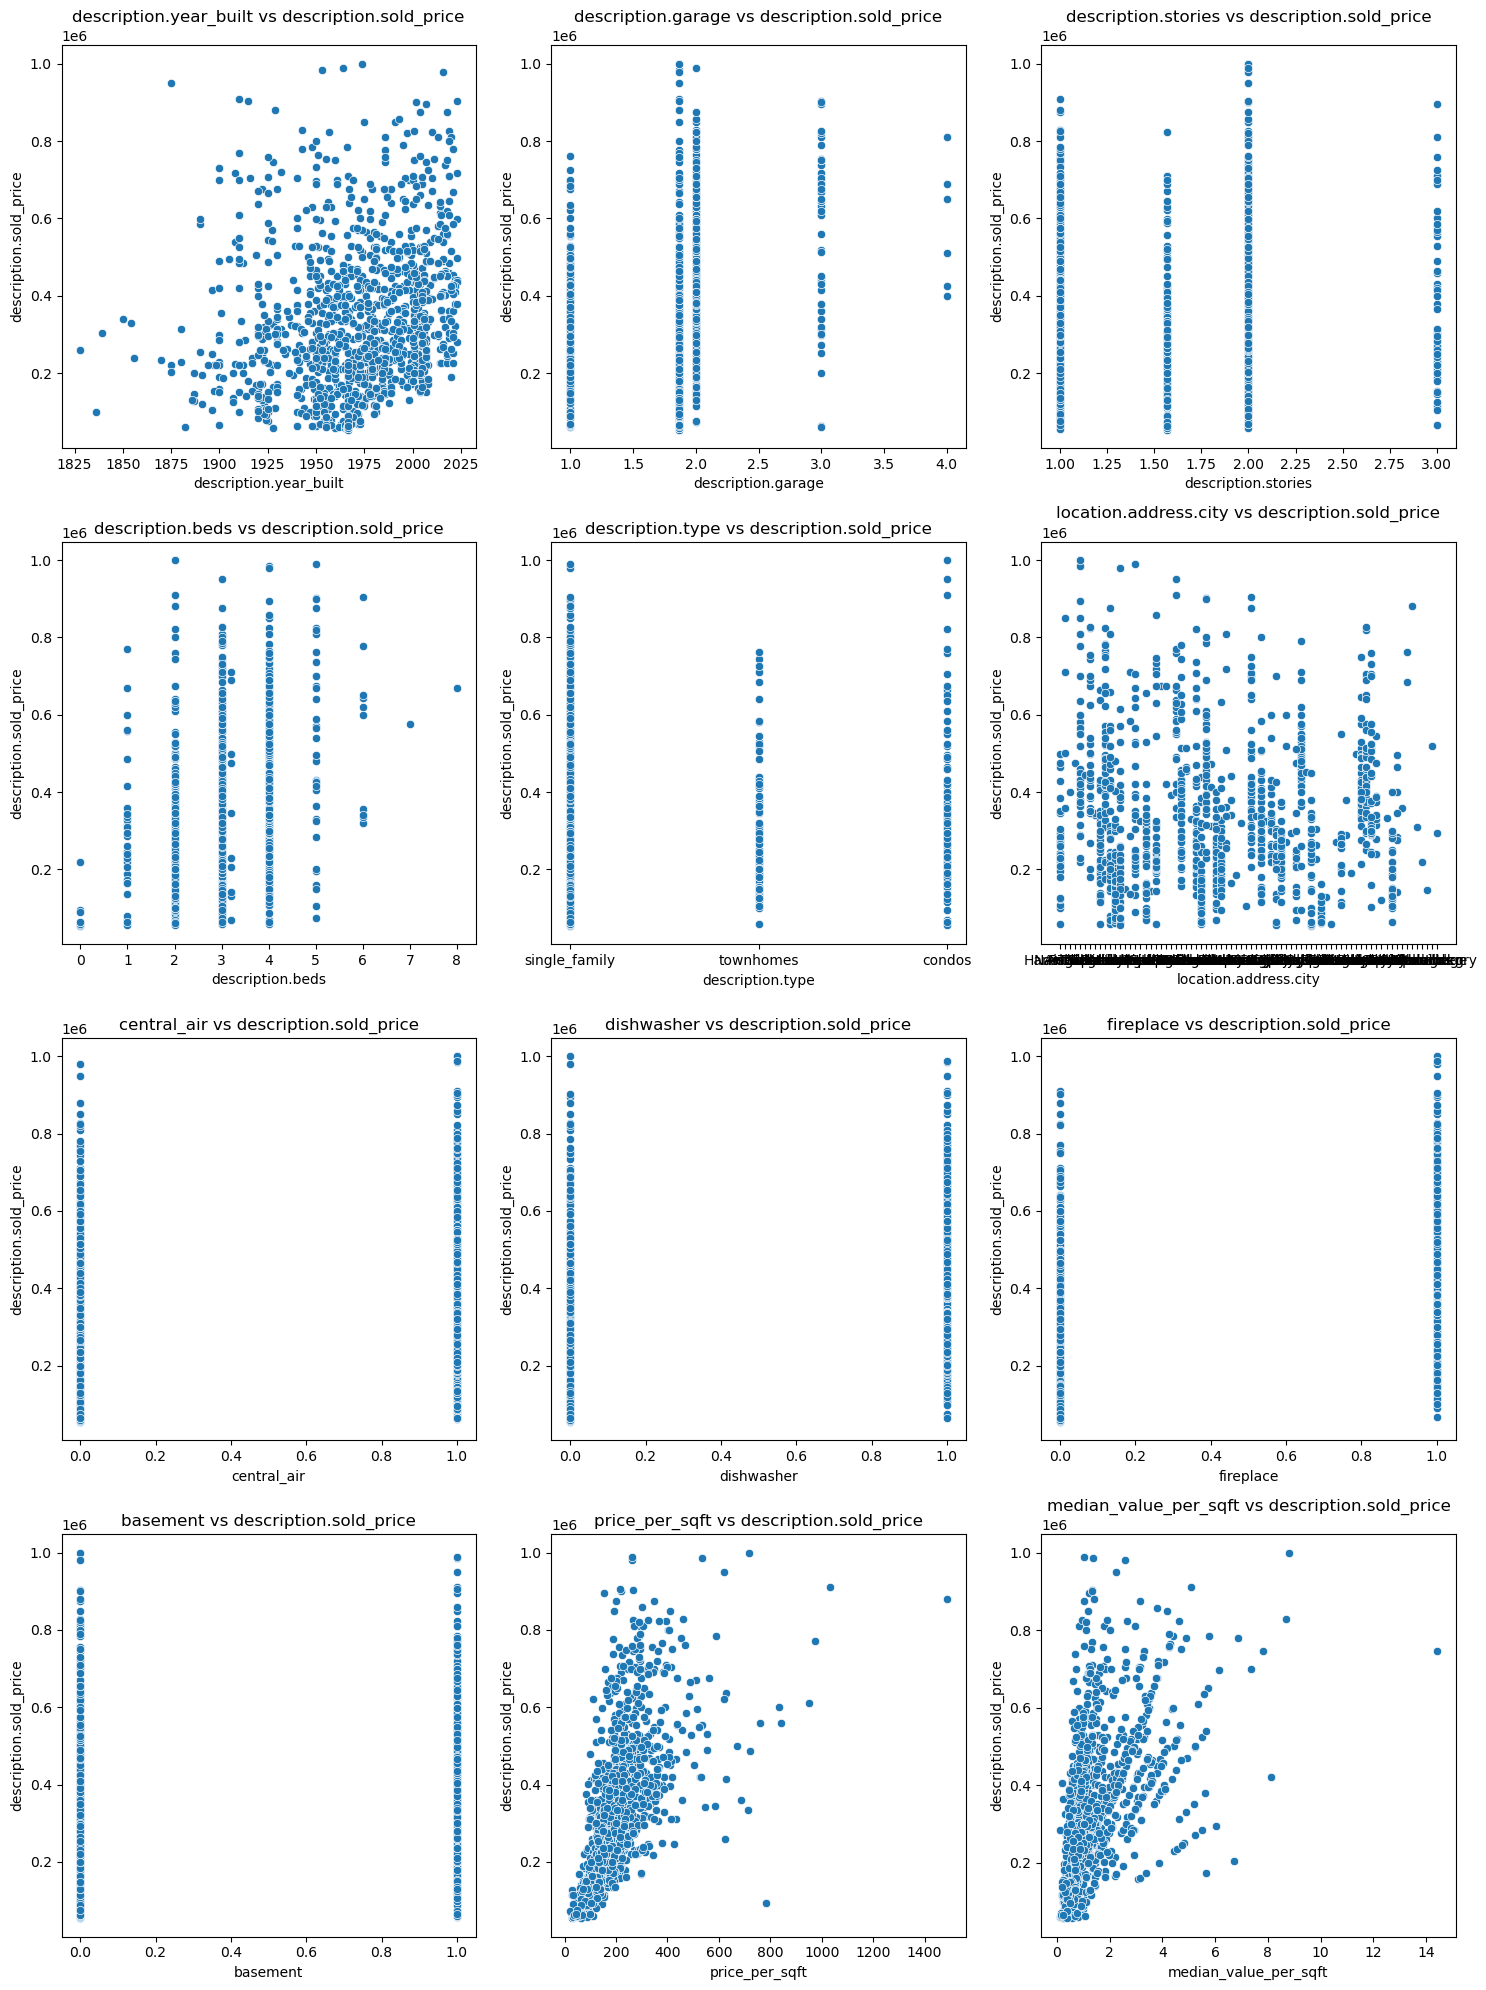

In [98]:
# perform EDA here, Scatter Plot
# Define the target variable
target = 'description.sold_price'# Determine the number of rows and columns for the subplots grid
num_features = len(features)
num_cols = 3  # Number of columns in the grid
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the features and create scatter plots in each subplot
for i, feature in enumerate(features):
    sns.scatterplot(x=df_result[feature], y=df_result[target], ax=axes[i])
    axes[i].set_title(f'{feature} vs {target}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)

# Remove any unused subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


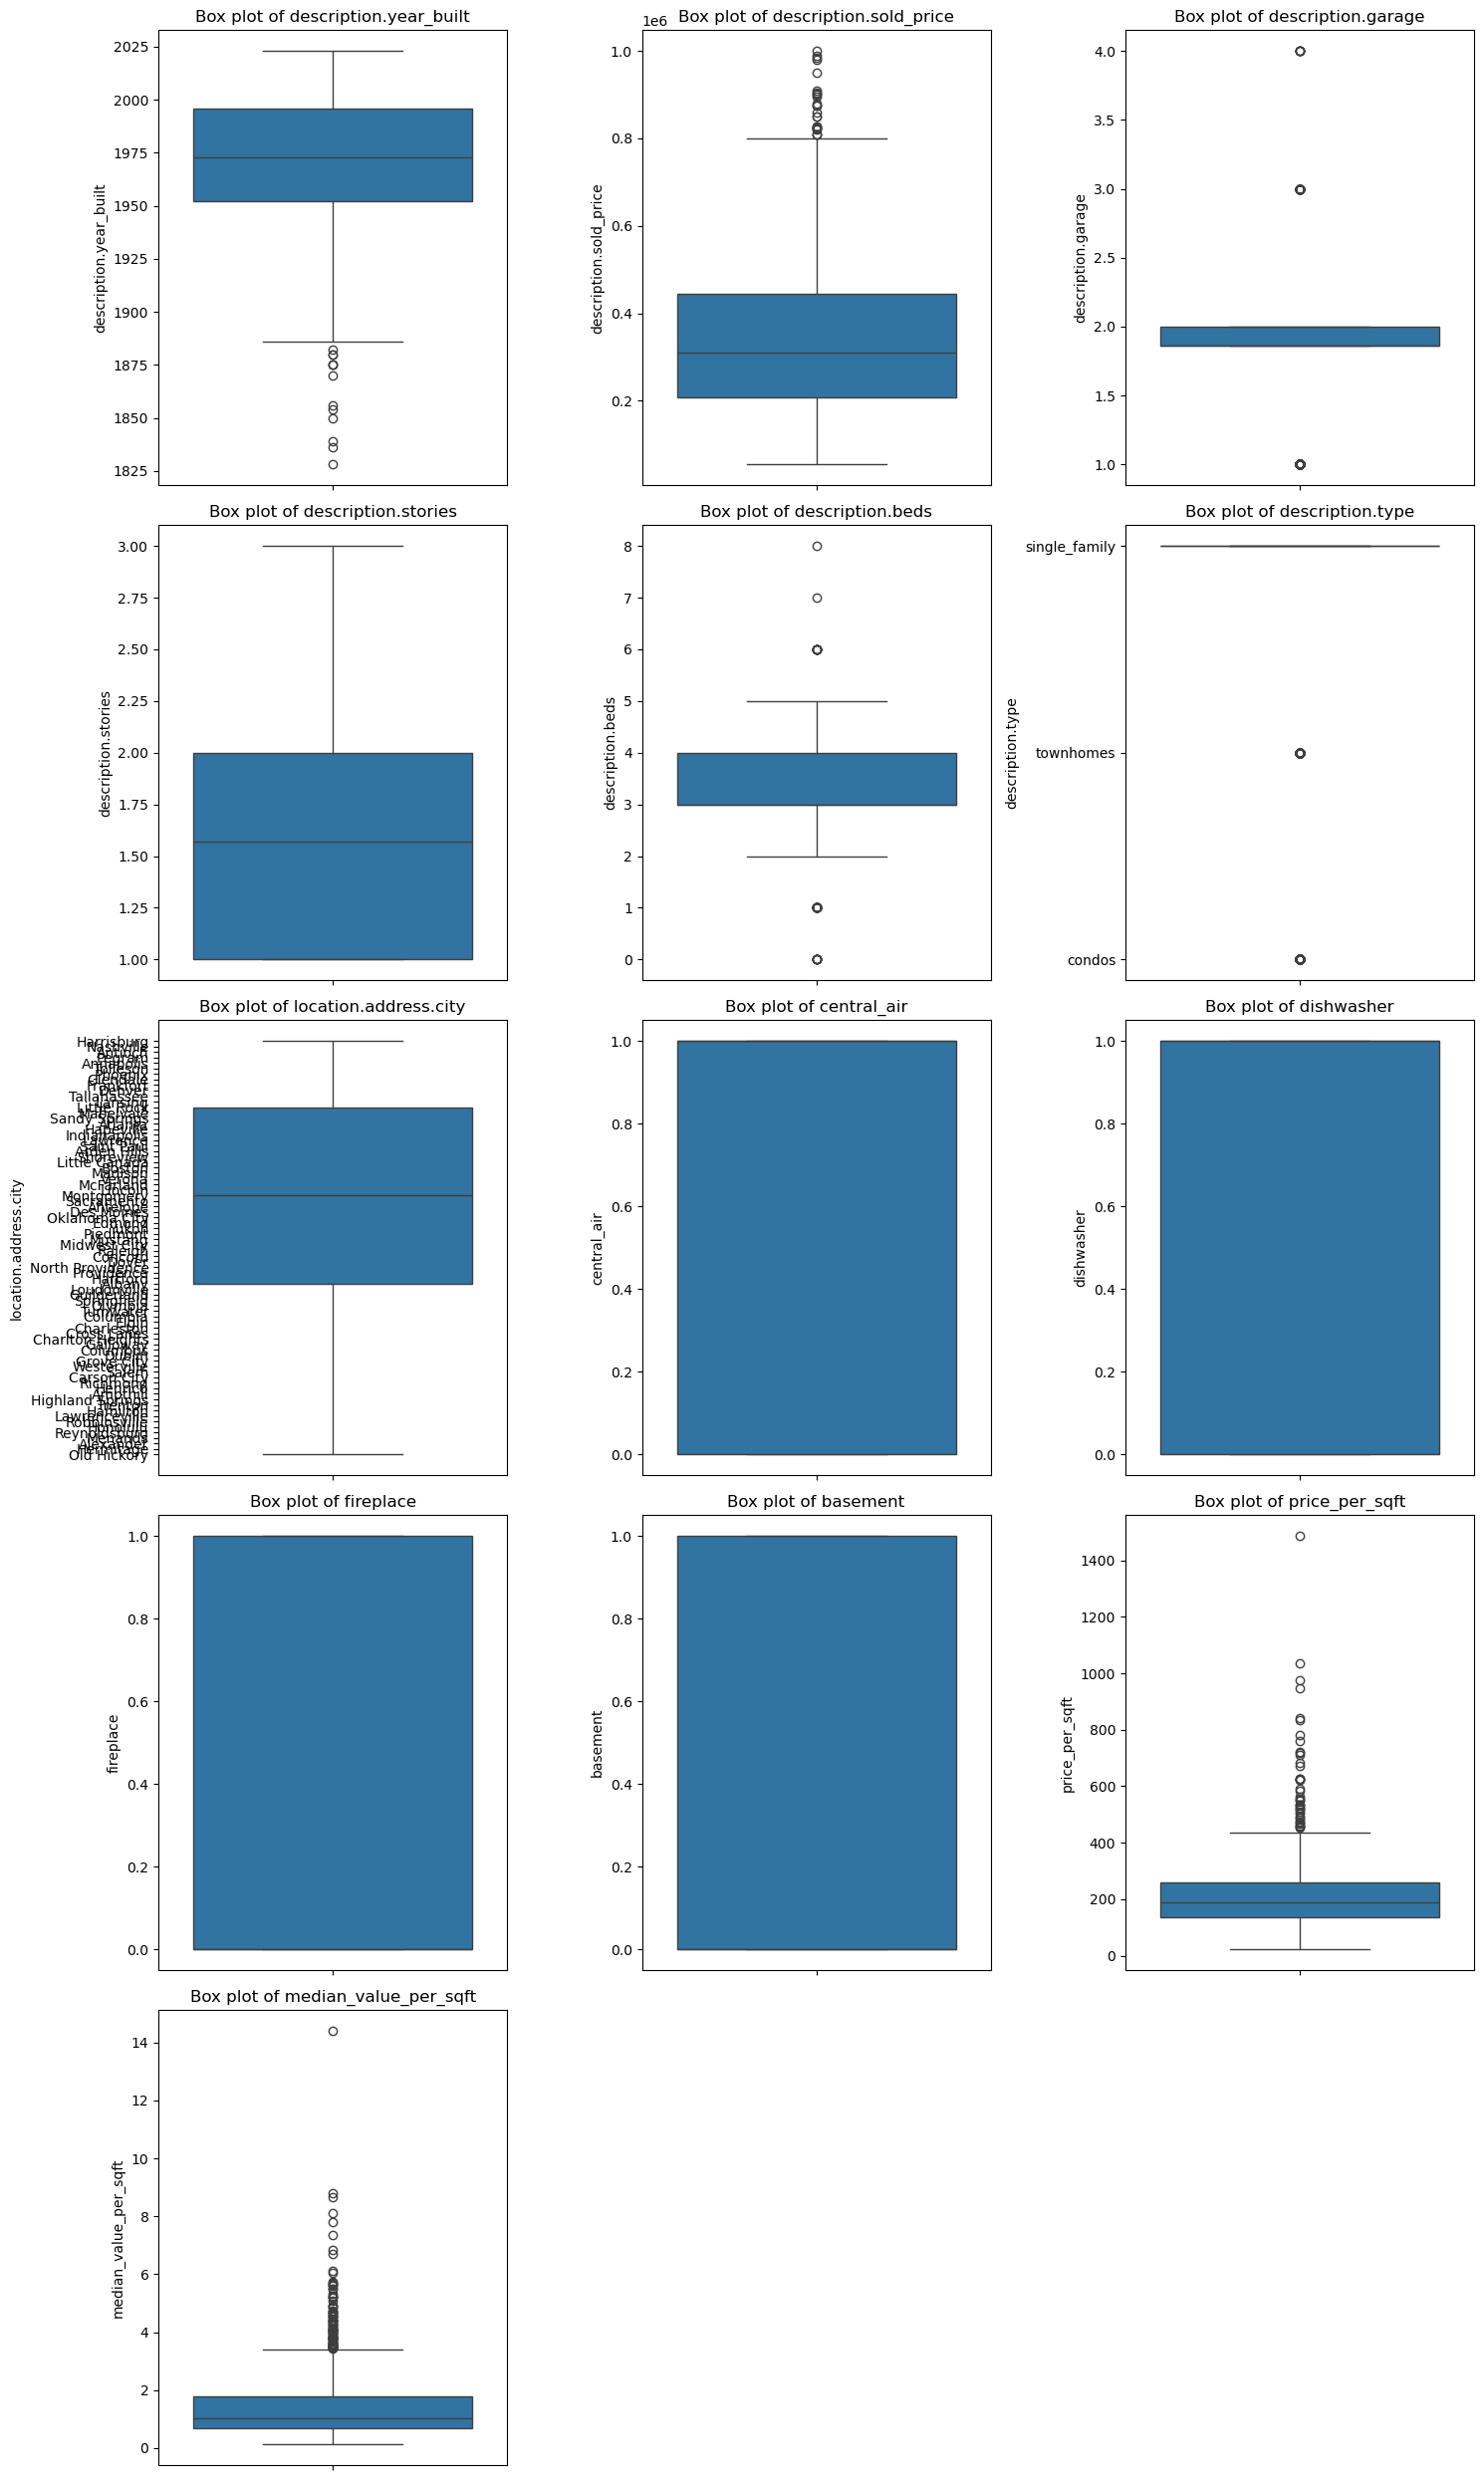

In [99]:
# Get the list of columns
columns = df_result.columns

# Determine the number of rows and columns for the subplots grid
num_cols = 3  # Number of columns in the grid
num_rows = (len(columns) + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the columns and create box plots in each subplot
for i, column in enumerate(columns):
    sns.boxplot(y=df_result[column], ax=axes[i])
    axes[i].set_title(f'Box plot of {column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column)

# Remove any unused subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

In [100]:
# Identify numeric columns in the training and test sets
numeric_cols_train = train_df.select_dtypes(include=[np.number]).columns.drop(target)
numeric_cols_test = test_df.select_dtypes(include=[np.number]).columns.drop(target)

# Convert all numeric columns to integers in train_df and test_df
train_df[numeric_cols_train] = train_df[numeric_cols_train].astype(int)
test_df[numeric_cols_test] = test_df[numeric_cols_test].astype(int)



In [101]:
train_df.shape

(903, 13)

In [102]:
test_df.shape

(226, 13)

In [103]:
# 2. Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
train_poly = poly.fit_transform(train_df[numeric_cols_train])
test_poly = poly.transform(test_df[numeric_cols_test])

# Convert polynomial features to DataFrame
train_poly_df = pd.DataFrame(train_poly, columns=poly.get_feature_names_out(numeric_cols_train))
test_poly_df = pd.DataFrame(test_poly, columns=poly.get_feature_names_out(numeric_cols_test))

# Add the target variable back to the polynomial DataFrames
train_poly_df[target] = train_df[target].reset_index(drop=True)
test_poly_df[target] = test_df[target].reset_index(drop=True)


In [104]:
# Display the polynomial DataFrames to verify the changes
train_poly_df.shape


(903, 91)

In [105]:
test_poly_df.shape

(226, 91)

                                            Feature  Importance
50                  description.beds price_per_sqft    0.650325
31                description.garage price_per_sqft    0.064675
41               description.stories price_per_sqft    0.017586
21     description.year_built median_value_per_sqft    0.016902
72                  fireplace median_value_per_sqft    0.014176
81             price_per_sqft median_value_per_sqft    0.012161
32         description.garage median_value_per_sqft    0.012057
14       description.year_built description.stories    0.010590
13        description.year_built description.garage    0.010340
18                 description.year_built fireplace    0.009828
15          description.year_built description.beds    0.009628
42        description.stories median_value_per_sqft    0.009586
51           description.beds median_value_per_sqft    0.008708
83                      price_per_sqft city_encoded    0.006486
71                         fireplace pri

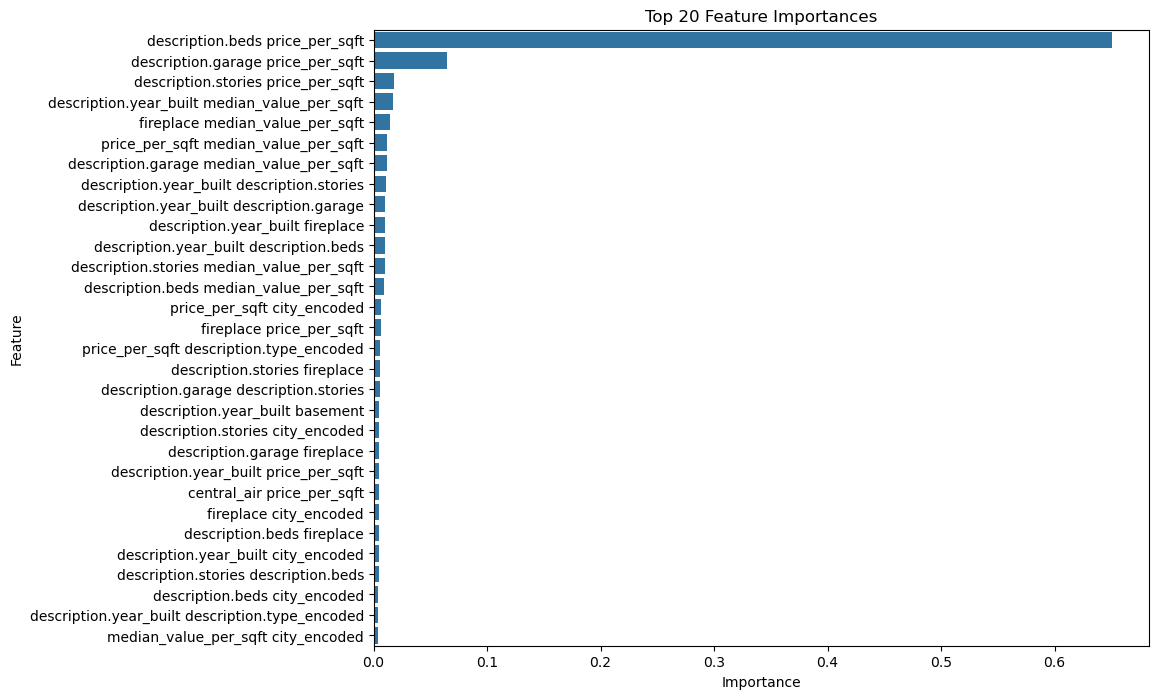

In [106]:
# Define the target variable
target = 'description.sold_price'

# Separate features and target
X_train = train_poly_df.drop(columns=[target])
y_train = train_poly_df[target]

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the top 20 features
top_features = feature_importances.head(30)
print(top_features)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Feature Importances')
plt.show()

# Create a new DataFrame with the top 30 features
top_feature_names = top_features['Feature'].tolist()
train_top_features_df = train_poly_df[top_feature_names + [target]]

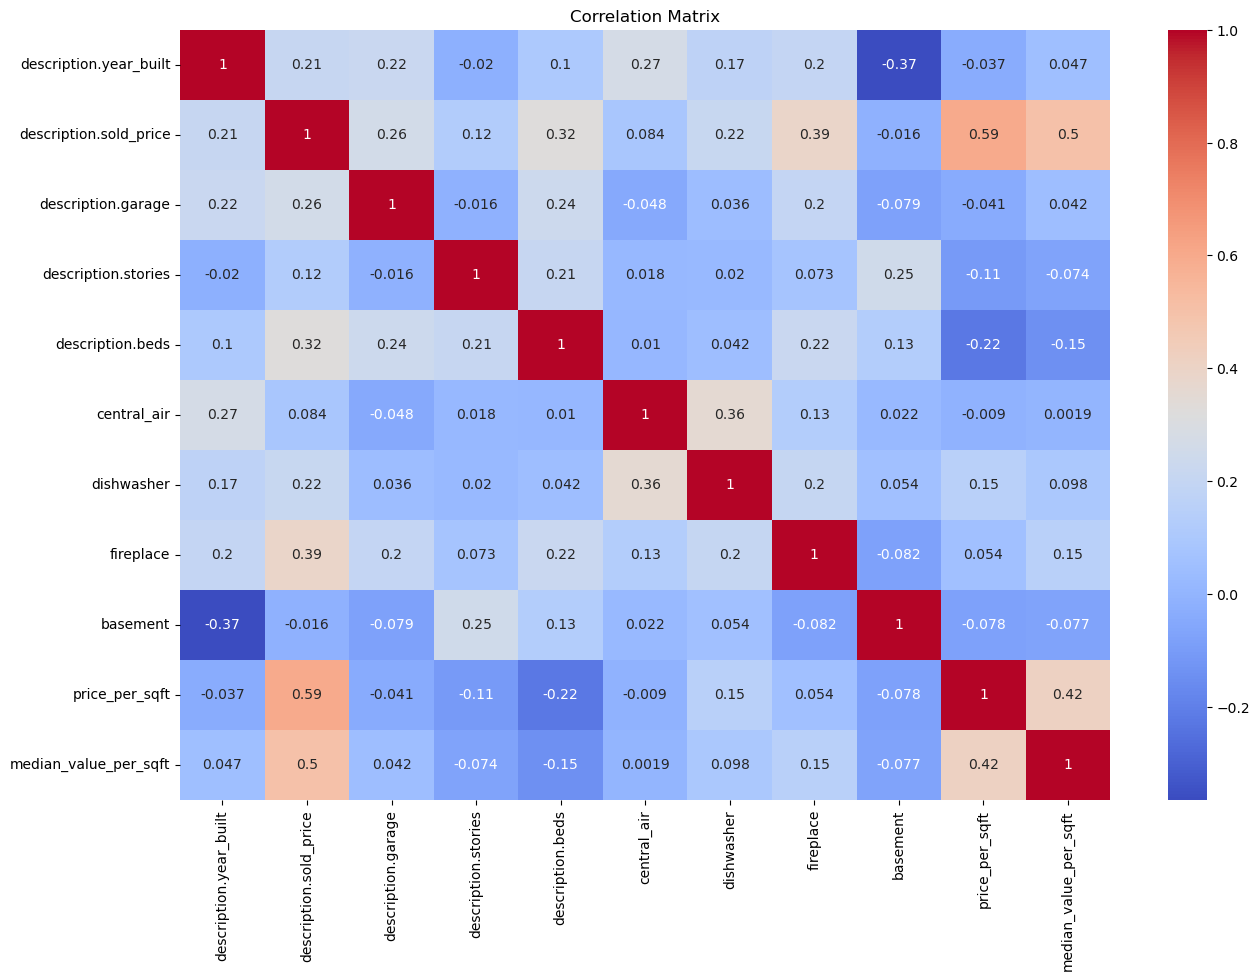

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming df_result is your DataFrame
# Select only numeric columns
numeric_columns = df_result.select_dtypes(include=[np.number]).columns.tolist()

# Assuming df_result is your DataFrame with the relevant features
# Calculate the correlation matrix
correlation_matrix = df_result[numeric_columns].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# # Check the correlation of the top features with other features
# top_features = ['description.baths price_per_sqft', 'description.beds price_per_sqft']
# print(correlation_matrix[top_features])

# # Ensure proper scaling (if not already scaled)
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(df_result[top_features])
# df_result_scaled = pd.DataFrame(scaled_features, columns=top_features)

# # Check the scaled values
# print(df_result_scaled.describe())

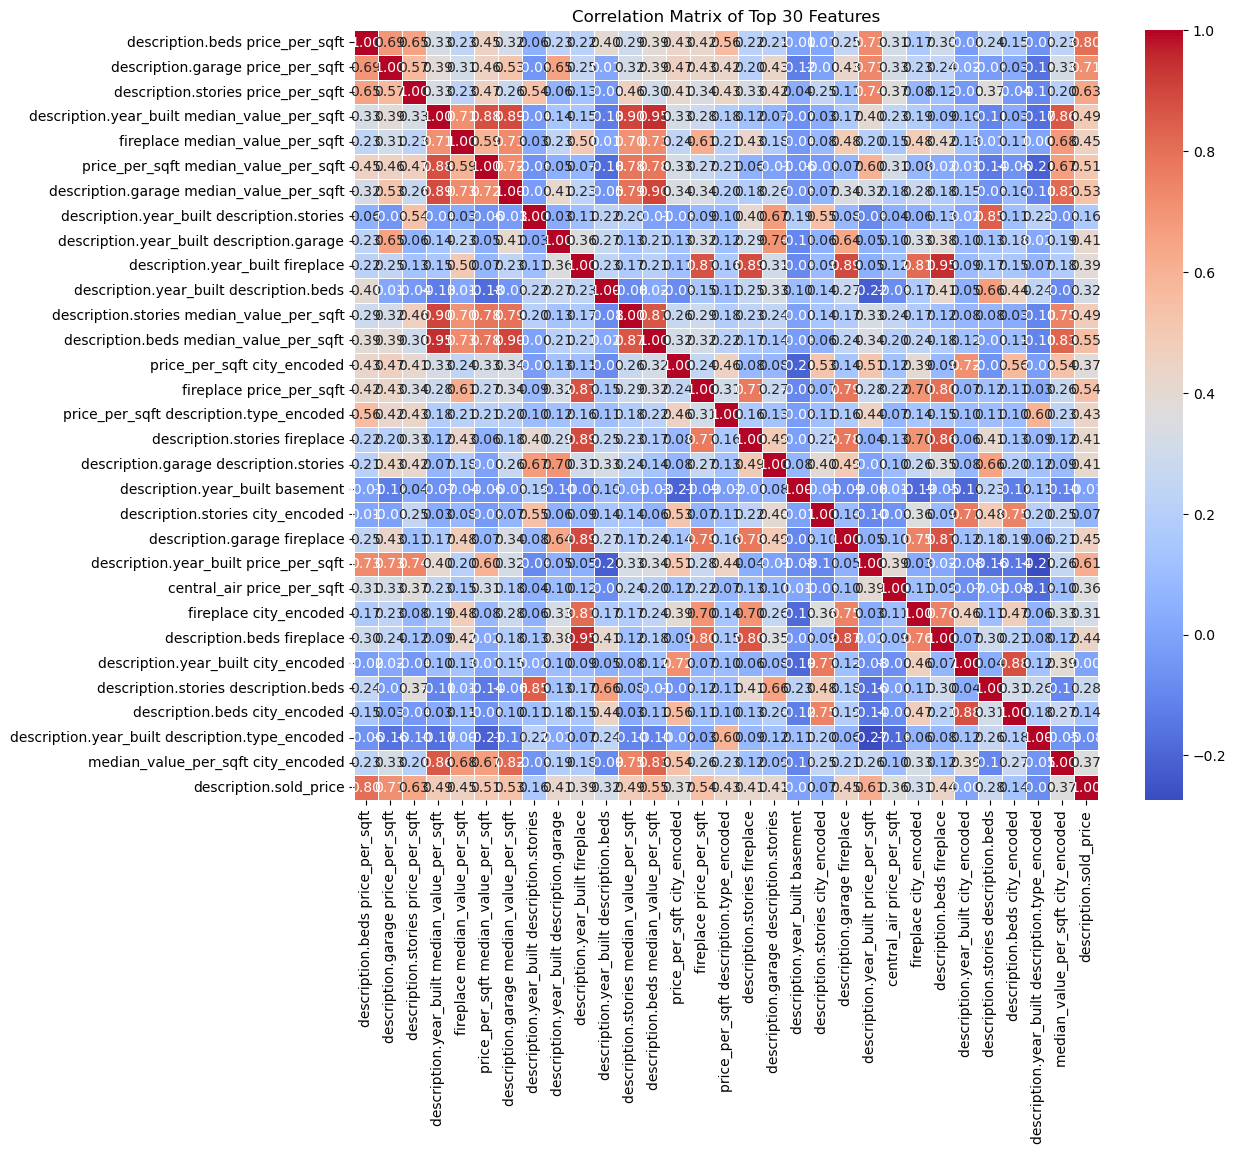

Highly correlated feature pairs:


,Feature1,Feature2,Correlation
0,price_per_sqft median_value_per_sqft,description.year_built median_value_per_sqft,0.877199
1,description.garage median_value_per_sqft,description.year_built median_value_per_sqft,0.888603
2,description.stories median_value_per_sqft,description.year_built median_value_per_sqft,0.904554
3,description.beds median_value_per_sqft,description.year_built median_value_per_sqft,0.948185
4,description.beds median_value_per_sqft,description.garage median_value_per_sqft,0.902834
5,description.beds median_value_per_sqft,description.stories median_value_per_sqft,0.865466
6,fireplace price_per_sqft,description.year_built fireplace,0.871250
7,description.stories fireplace,description.year_built fireplace,0.886488
8,description.garage fireplace,description.year_built fireplace,0.892796
9,description.beds fireplace,description.year_built fireplace,0.947079


In [109]:
# Calculate the correlation matrix
correlation_matrix = train_top_features_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Top 30 Features')
plt.show()

# Identify highly correlated features
threshold = 0.85
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

# Display highly correlated pairs
high_corr_pairs_df = pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
print("Highly correlated feature pairs:")
high_corr_pairs_df

## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [110]:
# Define the target variable
target = 'description.sold_price'

# Ensure that the same columns are used in both training and test sets
common_columns = train_poly_df.columns.intersection(test_poly_df.columns).tolist()

# Separate features and target in the training set
X_train_poly = train_poly_df[common_columns].drop(columns=[target])
y_train_poly = train_poly_df[target]

# Separate features and target in the test set
X_test_poly = test_poly_df[common_columns].drop(columns=[target])
y_test_poly = test_poly_df[target]

# Standardize the features using the same scaler fitted on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Save the scaled DataFrames to CSV files
train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_poly.columns)
train_scaled_df[target] = y_train_poly.reset_index(drop=True)
train_scaled_df.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/DS-Midterm-Project/DS-Midterm-Project/processed/train_scaled_1.csv', index=False)

test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_poly.columns)
test_scaled_df[target] = y_test_poly.reset_index(drop=True)
test_scaled_df.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/DS-Midterm-Project/DS-Midterm-Project/processed/test_scaled_1.csv', index=False)


# Save the DataFrames to CSV files
train_poly_df.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/DS-Midterm-Project/DS-Midterm-Project/processed/train_poly_2.csv', index=False)
test_poly_df.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/DS-Midterm-Project/DS-Midterm-Project/processed/test__poly_2.csv', index=False)

# Print the shapes of the scaled datasets
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)


Shape of X_train_scaled: (903, 90)
Shape of X_test_scaled: (226, 90)


Explained Variance Ratio: [0.19991067 0.13177897 0.11119981 0.10059563 0.07259867 0.05598207
 0.05373983 0.0515607  0.04577464 0.04076003 0.03233171 0.0127607
 0.00826561 0.00688857 0.00501879 0.00480131 0.00431171 0.00403334
 0.00367358 0.00319761 0.00310905]
Shape of train_pca_df: (903, 22)
Shape of test_pca_df: (226, 22)


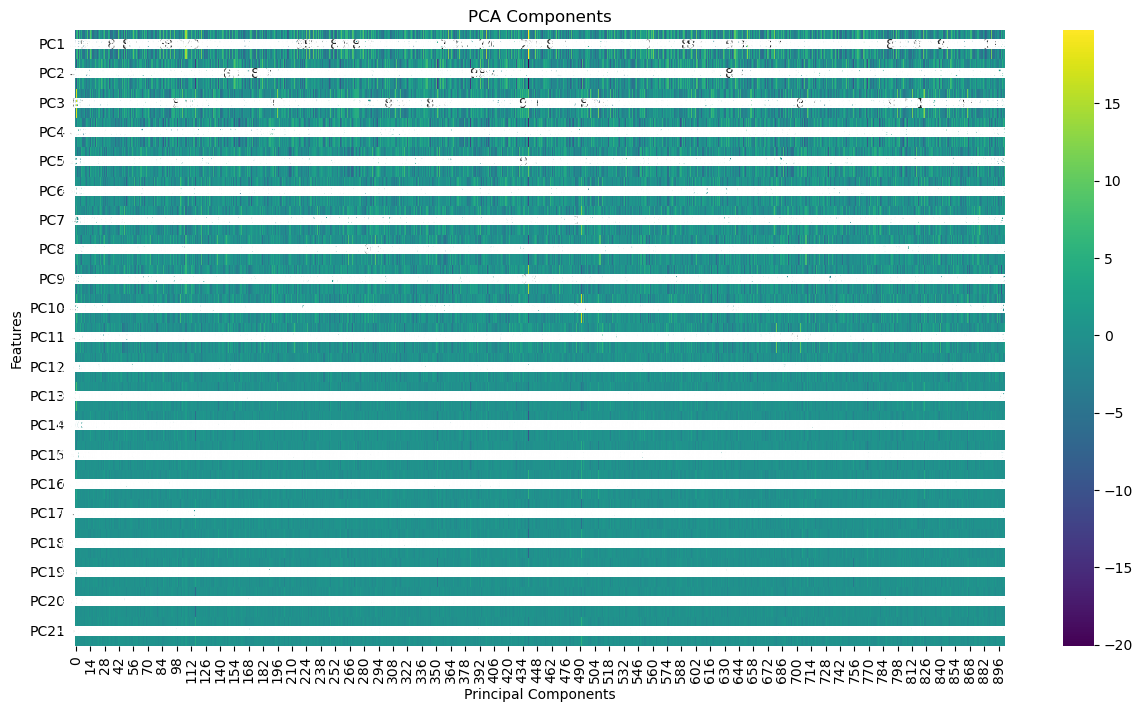

In [112]:

# Load your training and test data
dataframe_train_poly = pd.read_csv('/Users/blairjdaniel/lighthouse/lighthouse/DS-Midterm-Project/DS-Midterm-Project/processed/train_scaled_1.csv')
dataframe_test_poly = pd.read_csv('/Users/blairjdaniel/lighthouse/lighthouse/DS-Midterm-Project/DS-Midterm-Project/processed/test_scaled_1.csv')
target_column = 'description.sold_price'

# Separate features and target
X_train = dataframe_train_poly.drop(columns=[target_column])
y_train = dataframe_train_poly[target_column]
X_test = dataframe_test_poly.drop(columns=[target_column])
y_test = dataframe_test_poly[target_column]

# Standardize the features (if not already scaled)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Create DataFrames with the principal components
pca_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
train_pca_df[target_column] = y_train.reset_index(drop=True)

test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)
test_pca_df[target_column] = y_test.reset_index(drop=True)

# Save the DataFrames with principal components to CSV files
train_pca_df.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/DS-Midterm-Project/DS-Midterm-Project/processed/train_pca_1.csv', index=False)
test_pca_df.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/DS-Midterm-Project/DS-Midterm-Project/processed/test_pca_1.csv', index=False)

# Print the shapes of the DataFrames to verify
print("Shape of train_pca_df:", train_pca_df.shape)
print("Shape of test_pca_df:", test_pca_df.shape)

# Plot the PCA components
plt.figure(figsize=(15, 8))
sns.heatmap(train_pca_df.iloc[:, :-1].T, annot=True, cmap='viridis')
plt.title('PCA Components')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()